# Kalman Filter 

In [45]:
# include libraries
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Needed Functions

In [46]:
def CSV_Read_Lidar_data(data_path):
    rows = []
    with open(data_path, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            rows.append(row)

    dataframe = pd.DataFrame([rows[0], rows[1], rows[2], rows[3]], ['Rho', 'Alpha', 'X', 'Y'])

    return dataframe

In [47]:
def covarience_line_fitting(points_in_line, line_alpha_rho, sigma_angle=0, sigma_dist=.005):
    sigma_angle = sigma_angle * np.ones(len(points_in_line))
    sigma_dist = sigma_dist * np.ones(len(points_in_line))

    data = np.array(points_in_line)

    #INPUIT IS X AND Y POINTS WITHIN A LINE
    dist = line_alpha_rho[1]  # whatever positions stores the distances from 0,0
    angle = line_alpha_rho[0]  # whatever positions stores the angles with the x axis
    
    x = data[:,0]
    y = data[:,1]

    n = len(x)
    x_bar = sum(x) / n
    y_bar = sum(y) / n

    S_x2 = sum((x - x_bar) ** 2)
    S_y2 = sum((y - y_bar) ** 2)
    S_xy = sum((x - x_bar) * (y - y_bar))

    # line paramters based on inputs data
    alpha = 0.5 * math.atan2(-2 * S_xy, S_y2 - S_x2)
    rho = x_bar * math.cos(alpha) + y_bar * math.sin(alpha)

    C_l = np.zeros(2)
    for i in range(0, n - 1):
        # The covariance of the measurement
        C_m = np.array([[sigma_angle[i], 0],
                        [0, sigma_dist[i]]])
        A = np.zeros((2, 2))

        # The jacobian of the line fit with respect to x and y
        A[1, 0] = ((y_bar - y[i]) * (S_y2 - S_x2) + 2 * S_xy * (x_bar - x[i])) / ((S_y2 - S_x2) ** 2 + 4 * S_xy ** 2)

        A[1, 1] = ((x_bar - x[i]) * (S_y2 - S_x2) - 2 * S_xy * (y_bar - y[i])) / ((S_y2 - S_x2) ** 2 + 4 * S_xy **2)

        A[0, 0] = math.cos(alpha) / n - x_bar * math.sin(alpha) * A[1, 0] + y_bar * math.cos(alpha) * A[1, 0]
        A[0, 1] = math.sin(alpha) / n - x_bar * math.sin(alpha) * A[1, 1] + y_bar * math.cos(alpha) * A[1, 1]

        # Jacobian of function converting dist and angle to x and y

        B = np.array([[math.cos(angle), -dist * math.sin(angle)],
                      [math.sin(angle), dist * math.cos(angle)]])
        J = A @ B
        C_l = C_l + J * C_m * J.T

    return rho, alpha, C_l

In [48]:
# Bunch of algorithms for split and merge

def GetPolar(X, Y):
    # center the data
    X = X - np.mean(X)
    Y = Y - np.mean(Y)
    # fit line through the first and last point (X and Y contains 2 points, start and end of the line)
    k, n = np.polyfit(X, Y, 1)
    alpha = math.atan(-1 / k)  # in radians
    ro = n / (math.sin(alpha) - k * math.cos(alpha))
    return ro, alpha

def Cartesian2Polar(x, y):
    r = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return r, phi

def CheckPolar(ro, alpha):
    if ro < 0:
        alpha = alpha + math.pi
        if alpha > math.pi:
            alpha = alpha - 2 * math.pi
        ro = -ro
    return ro, alpha

def getDistance(P, Ps, Pe):  # point to line distance, where the line is given with points Ps and Pe
    if np.all(np.equal(Ps, Pe)):
        return np.linalg.norm(P - Ps)
    return np.divide(np.abs(np.linalg.norm(np.cross(Pe - Ps, Ps - P))), np.linalg.norm(Pe - Ps))

def GetMostDistant(P):
    dmax = 0
    index = -1
    for i in range(1, P.shape[0]):
        d = getDistance(P[i, :], P[0, :], P[-1, :])
        if (d > dmax):
            index = i
            dmax = d
    return dmax, index

def points_within_radius(mainpoint, points, r):
    result = []
    for point in points:
        if math.dist(mainpoint, point) <= r:
            result.append(point)
    return result

def gap_detection(lines, points, threshold):
    good_lines = []
    points_in_thresh_total = []
    for i in range(len(lines)):
        # get point 1 and point 2 of the line
        point_1 = lines[i][0]
        point_2 = lines[i][1]

        # get the distance of the line, then take a certain percentage of it (remember its based off both sides)
        line_dist = math.dist(point_2, point_1)
        r = line_dist / 2 * 0.10
        # print(r)

        # check all the points to see if they fall in theshold, store if they do
        points_in_thresh = []

        for j in range(len(points)):
            # distance = point_to_line_distance(points[j], lines[i])
            distance = getDistance(points[j], lines[i][0], lines[i][1])
            if distance <= (threshold * 1):
                # if distance < r:
                points_in_thresh.append(points[j])
        
        if len(points_in_thresh) <= 5 and line_dist <= 0.3:
            good_lines.append(lines[i])
            points_in_thresh_total.append(points_in_thresh)
            continue

        # check to see what % of points are between the threshold of the first and last point (might need my own threshold)
        p1_points = points_within_radius(point_1, points_in_thresh, r)
        p2_points = points_within_radius(point_2, points_in_thresh, r)
        # print(len(p1_points))
        # print(len(p2_points))
        # print(len(points_in_thresh))

        percent_in_radius = (len(p1_points) + len(p2_points)) / (len(points_in_thresh))
        # print(percent_in_radius)

        if percent_in_radius <= 0.40:
            # print("good line")
            good_lines.append(lines[i])
            points_in_thresh_total.append(points_in_thresh)
        # else:
        #     print("bad line")
        # plt.show()
        # print("\n")
        
    return good_lines, points_in_thresh_total

def SplitAndMerge(P, threshold):
    d, ind = GetMostDistant(P)
    if d > threshold:
        P1 = SplitAndMerge(P[:ind + 1, :], threshold)  # split and merge left array
        P2 = SplitAndMerge(P[ind:, :], threshold)  # split and merge right array
        # there are 2 "d" points, so exlude 1 (for example from 1st array)
        points = np.vstack((P1[:-1, :], P2))
    else:
        points = np.vstack((P[0, :], P[-1, :]))
    return points

def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

def Algorithm_split_and_merge(inputdataframe, threshold=0.3, plot=False):

    P = np.array([list(inputdataframe['X']), list(inputdataframe['Y'])]).T

    points = SplitAndMerge(P, threshold)

    lines = []
    for i in range(len(points) - 1):
        lines.append([points[i], points[i + 1]])
        # plt.plot([points[i][0], points[i+1][0]], [points[i][1], points[i+1][1]], '-o')
    # final_lines = lines
    final_lines, points_in_line = gap_detection(lines, P, threshold)

    # flatten it to get the shitty points
    flat_list = flatten(final_lines)
    flat_list.append(flat_list[0])
    flat_list = np.array(flat_list)

    #convert from xy back to alpha rho
    alpha_rho = []
    for i in range(len(final_lines)):
        alpha, rho = GetPolar([final_lines[i][0][0], final_lines[i][1][0]], [final_lines[i][0][1], final_lines[i][1][1]])
        alpha_rho.append([alpha, rho])

    if plot==True:
        # plt.figure()
        # plt.title('og')
        # plt.scatter(P[:, 0], P[:, 1], c='black')
        # plt.plot(points[:, 0], points[:, 1])

        # plt.figure()
        # plt.title('with gap detection')
        # plt.scatter(P[:, 0], P[:, 1], c='black')
        # plt.plot(flat_list[:, 0], flat_list[:, 1], '-o')

        plt.figure()
        plt.title('actual Lines')
        plt.scatter(P[:, 0], P[:, 1], c='black')
        for i in range(len(final_lines)):
            tmp = np.array(final_lines[i])
            plt.plot(tmp[:, 0], tmp[:, 1], '-o')
        # print(len(lines))
        # print(len(final_lines))
        plt.scatter(0, 0, c='red')  # replace this with the origin point
        plt.show()

    return final_lines, points_in_line, alpha_rho

In [49]:
def matching(z_hat_t,z_t,R_t,H_j,P_hat_t,g):

    matches = []
    v_t_matches = []
    sigmas_matches = []
    H_matches = []
    #initializedng vt

    v_t = np.zeros((2,1,len(z_t),len(z_hat_t)))
    sigma_itt = np.zeros((2,2,len(z_t),len(z_hat_t)))
    #This could be vectorized or whatever but i think itll be okay
    for i in range(len(z_t)):
        for j in range(len(z_hat_t)):
            v_t[:,:,i,j] = z_t[:,:,i] - z_hat_t[:,:,j]
            
            sigma_itt[:,:,i,j] = H_j[:,:,j] @ P_hat_t @ H_j[:,:,j].T + R_t[i]
    # Mahalanobis distance
    for i in range(len(z_t)):
        for j in range(len(z_hat_t)):
            v_ = v_t[:,:,i,j]
            sigma_ = sigma_itt[:,:,i,j]
            # print(v_)
            # print(v_.T)
            mah_dist = v_.T @ sigma_ @ v_
            # print(mah_dist)
            if mah_dist <= g**2:
                matches.append([i,j])
                v_t_matches.append(v_t[:,:,i,j])
                sigmas_matches.append(sigma_itt[:,:,i,j])
                H_matches.append(H_j[:,:,j])
                
    return matches, v_t_matches, sigmas_matches,H_matches

In [50]:
def pos_estimation(H_t, x_hat, v_t,P_t_hat,sigmas):
 
    #for number of matched lines
    for i in range(len(H_t)):
        K_t = P_t_hat @ H_t[i].T @ np.linalg.pinv(sigmas[i])
        # print(f'H_t = {H_t}')
        P_t = P_t_hat - K_t @ sigmas[i] @ K_t.T

        x_t = x_hat + K_t @ v_t[i]
        x_hat = x_t

    if len(H_t) == 0:
        x_t = x_hat
        P_t = P_t_hat
        return x_t, P_t

    
    return x_t, P_t

In [51]:
def pos_estimation_v2(H_t, x_hat, v_t,P_t_hat,sigma):
 
    #for number of matched lines
    
    K_t = P_t_hat @ H_t.T @ np.linalg.pinv(sigma)
    # print(f'H_t = {H_t}')
    P_t = P_t_hat - K_t @ sigma @ K_t.T

    x_t = x_hat + K_t @ v_t
    x_hat = x_t

   
    return x_t, P_t

In [52]:
def measurement_prediction(x_hat, gt_map_df):
    """
    The measurements needs to take the MAP data and move the lines into the Robts frame (from world) THEN match lines together or something
    x_hat = 
    map = gt map
    data = observed map data
    """
    N = int(gt_map_df.shape[1])
    z_hat_t = np.zeros([2, 1, N]) # The pridiction of what the Lines detected should be, from map
    alpha_map = gt_map_df.loc['Alpha'].astype(float)
    rho_map = gt_map_df.loc['rhos'].astype(float)

    z_hat_t[0,0,:] = alpha_map[:] - x_hat[2] # removing the robots orientation in the world to rotate the line angles into frame
    z_hat_t[1,0,:] = rho_map[:]-x_hat[0]*np.cos(alpha_map[:])+x_hat[1]*np.sin(alpha_map[:]) # translation portion for the lines

    H_j = np.zeros([2,3,N])

    for k in range(N):
        H_j[:,:,k] = np.array([[0,  0,  -1],  
                    [-np.cos(alpha_map[k]), -np.sin(alpha_map[k]), 0]])  #it might not be able to handle this notation. Could easily be a loop

    return z_hat_t,H_j

In [53]:
# TODO pos_t_minus1 needs to be updated to previous x_hat_t after initial time step -Rob

In [54]:
def position_prediction(pos_t_minus1, delta_sl, delta_sr, b,P_t_minus1):

    delta_sl
    delta_sr

    theta_t_minus1 = pos_t_minus1[2]
  
    x_hat = np.empty((3,1))

    

    # This is previous postion + estimate of future position
    x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
                                    [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
                                    [(delta_sr-delta_sl) / b]]))
    
    delta_s = (delta_sr+delta_sl)/2
    delta_theta = (delta_sr-delta_sl) / b

    k_r =  .001
    k_l =  .001

    Q_t  = np.array([[k_r * abs(delta_sr), 0],
                    [0, k_l * abs(delta_sl) ]])
    F_deltarl = np.array([  [.5*math.cos(theta_t_minus1+delta_theta/2)-delta_s/2/b*math.sin(theta_t_minus1+delta_theta/2),.5*math.cos(theta_t_minus1+delta_theta/2)+delta_s/2/b*math.sin(theta_t_minus1+delta_theta/2)],
                            [.5*math.sin(theta_t_minus1+delta_theta/2)+delta_s/2/b*math.cos(theta_t_minus1+delta_theta/2),.5*math.sin(theta_t_minus1+delta_theta/2)-delta_s/2/b*math.cos(theta_t_minus1+delta_theta/2)],
                            [1/b,-1/b]])

    F_k_minus_1 = np.array([[1, 0, -delta_s*math.sin(theta_t_minus1+delta_theta/2)],
                            [0, 1,  delta_s*math.cos(theta_t_minus1+delta_theta/2)],
                            [0, 0, 1]])
    
    #TODO PUT IN THE FU MATRICXZ
    # @ is matrix multiplication
    P_t_minus1_2 = P_t_minus1 * np.identity(3)
    P_hat_t = F_k_minus_1 @ P_t_minus1_2 @ F_k_minus_1.T + F_deltarl@ Q_t @ F_deltarl.T
    # pos_t_minus1 = x_hat
    return x_hat, P_hat_t

# Initializing map


Ground Truth Map Generation

In [55]:
file_path = 'Data_Readers_Writers/Data/'
file_name = 'DownstairsScan_not_move_GT_LineData'
# file_name = 'Downstairsdata_GT_LineData'

data_path = file_path + file_name + '.pkl'

ground_truth_df = pd.read_pickle(data_path)
ground_truth_df = ground_truth_df.T
ground_truth_df

,0,1,2,3,4,5,6,7,8,9,...,72,73,74,75,76,77,78,79,80,81
Alpha,1.528933,-0.041175,-0.639583,1.128703,-1.018859,-1.497866,-0.048548,1.242191,-0.196845,-1.387999,...,-0.035465,-1.078447,0.090297,1.540337,-0.951685,1.516715,-0.817356,1.386155,-0.050623,1.518756
rhos,-1.398482,6.485009,7.59319,-0.951883,9.276771,5.828866,4.942724,1.000041,4.538875,1.093727,...,4.926635,1.973851,5.09891,1.914135,-0.106735,1.619326,-0.080885,1.393266,0.822196,1.61811
Covariance,"[[1.4555015353985783e-09, 0.0], [0.0, 6.362433...","[[0.005981340029956629, 0.0], [0.0, 5.71429541...","[[0.0008748717973357287, 0.0], [0.0, 0.0084381...","[[1.934309383732514e-06, 0.0], [0.0, 7.9765064...","[[0.036633361399042726, 0.0], [0.0, 0.01104819...","[[4.6447851608477636e-05, 0.0], [0.0, 0.000661...","[[2.205959962349593e-06, 0.0], [0.0, 7.2596445...","[[8.044530938787486e-07, 0.0], [0.0, 5.1053556...","[[3.525275431347958e-05, 0.0], [0.0, 6.3848124...","[[1.4232551286207996e-07, 0.0], [0.0, 7.326368...",...,"[[2.6514062105338167e-06, 0.0], [0.0, 4.811054...","[[3.469228555854677e-06, 0.0], [0.0, 9.9762617...","[[2.0904623401293395e-05, 0.0], [0.0, 2.187326...","[[3.747290198379295e-08, 0.0], [0.0, 3.6479133...","[[3.959373773899206e-06, 0.0], [0.0, 5.0906425...","[[3.0498013163140266e-09, 0.0], [0.0, 7.774659...","[[3.0685515377954927e-06, 0.0], [0.0, 3.070852...","[[8.3249982917495e-08, 0.0], [0.0, 6.777710364...","[[5.109496126744668e-06, 0.0], [0.0, 1.1854879...","[[2.460134558921752e-09, 0.0], [0.0, 5.5117093..."
Lines_(endpoints),"[[0.008152954618842993, -1.4039763717795215], ...","[[6.258016649308644, -4.906274947628477], [6.2...","[[6.228536477844267, -4.270601601129469], [6.4...","[[6.420783042874593, -4.081079035993247], [9.0...","[[9.090249923490891, -5.342591637984422], [9.3...","[[9.325660242370995, -5.122662232645176], [10....","[[4.839291570539102, -1.9675957044508525], [4....","[[4.905512354160249, -0.6156965504840072], [4....","[[4.525753944453946, -0.48811438311895666], [4...","[[4.569036792890612, -0.25235043152339126], [4...",...,"[[4.9244883747137544, -0.18600533359420515], [...","[[4.934459464359772, 0.4164314979423046], [5.0...","[[5.064666355671715, 0.4867205371300136], [4.9...","[[4.937863383954888, 1.7773606057528046], [2.4...","[[2.4204055380131626, 1.8525500329389983], [1....","[[1.979545860093206, 1.5334320754059498], [1.5...","[[1.5604549321799335, 1.564953856586494], [1.1...","[[1.1527930461452152, 1.1832886498696593], [0....","[[0.8836948105030336, 1.2342639515749838], [0....","[[0.9012990914707864, 1.5857603700411165], [-5..."
Points_within_line,"[[0.008152954618842993, -1.4039763717795215], ...","[[6.258016649308644, -4.906274947628477], [6.2...","[[6.228536477844267, -4.270601601129469], [6.2...","[[0.5743819549423546, -1.4245635861035562], [0...","[[9.090249923490891, -5.342591637984422], [9.1...","[[9.29575597651457, -5.176729482115324], [9.32...","[[4.839291570539102, -1.9675957044508525], [4....","[[4.901962050651213, -0.7021918910551128], [4....","[[4.530791838903417, -0.5152909767069598], [4....","[[4.5639475243253225, -0.3319050320241136], [4...",...,"[[4.839291570539102, -1.9675957044508525], [4....","[[1.2877492887309843, -1.4509658822275002], [1...","[[5.003666694550037, 0.4515498824871636], [5.0...","[[4.960502196179552, 1.688495058629504], [4.95...","[[2.5802720319183767, 1.8586545310723082], [2....","[[5.033523948091735, 1.2060737490589615], [5.0...","[[1.6888472576099294, 1.5613438830438124], [1....","[[4.928818655176071, 0.38714385373536986], [4....","[[0.6549158432821173, -1.429079886560556], [0....","[[5.034204207156025, 1.2371920460687211], [5.0..."


# 1. Robot Position Prediction

In [56]:
'''
robot pos prediction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
'''
# Some values that are global


b = .235 # distance between robots wheels (meters)
wheel_radius = 0.072 # radius of the actual wheel (meters)

"""
These are the uncertainties in the are error constants representing the 
nondeterministic parameters of the motor drive and the wheel-floor interaction. Probably can be found in DOC or just tune for it
"""

# Pull these from ros, page 337, displacewmnt of left and right wheel
# ut = [delta_sl, delta_sr].T
#TODO When converting to robot version, get these update every time step
delta_sl = 0.0
delta_sr = 0.0

# pos_t_minus1 is the [x_t-1, y_t-1, theta_t-1] position of the robot x_t-1
# the robot drives forward with the control input ut (above) to a position vector xt
# Both are world frames
#TODO get a value for this
pos_t_minus1 = np.array([[0],
                        [0],
                        [0]])
# initialize covarience matrix TODO intiialize this beter
# P_t_minus1 = 0.1
P_t_minus1 = np.array([[9, 0, 0],
                    [0, 9, 0],                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
                    [0, 0, .9]])

g = 0.1

# 2. Observation

In [57]:
# Load datapath and put into dataframe
# path to csv data
data_path = 'Data_Readers_Writers/Data/DownstairsScan_not_move_scan_data_organized.csv'
# data_path = 'Data_Readers_Writers/Data/DownstairsScanV2_scan_data_organized.csv'

tmp_df = pd.read_csv(data_path)

#read and turn to list
lowrange = 0
highrange = 1070

scan_df = []
for i in range(int(tmp_df.shape[0]/1070)):
    lowrange = 0 + 1070 * i
    highrange = lowrange + 1070
    scan_df.append(tmp_df.iloc[lowrange:highrange, :])

# Delete any column that has an inf in the rho spot
for i in range(len(scan_df)):
    inf_cols = scan_df[i]['Rho'][np.isfinite(scan_df[i]['Rho'])]
    # print(inf_cols.index)
    scan_df[i] = scan_df[i].T[inf_cols.index].T.reset_index(drop=True)
scan_df[0]

,Rho,Alpha,X,Y
0,1.404012,0.004136,1.403976,0.008153
1,1.404048,0.008272,1.403905,0.016306
2,1.406108,0.012390,1.405787,0.024493
3,1.406192,0.016519,1.405621,0.032656
4,1.404300,0.020677,1.403408,0.040759
...,...,...,...,...
829,6.347022,1.348068,1.395949,-0.130121
830,6.352685,1.348270,1.396681,-0.122012
831,6.358349,1.348472,1.397366,-0.113900
832,6.364455,1.348367,1.399998,-0.105934


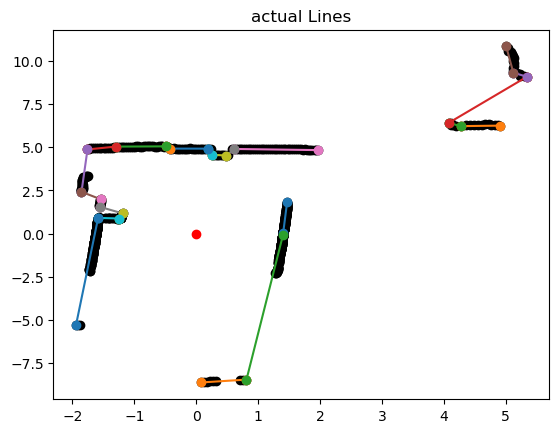

[array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.3567653e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00976668]]), array([[0.        , 0.        ],
       [0.        , 0.02140113]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.96840878e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00415316]]), array([[0.000000e+00, 0.000000e+00],
       [0.000000e+00, 6.283847e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.05942716e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.59037847e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00036357]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.78090533e-08]]), array([[0.        , 0.        ],
       [0.        , 0.00010573]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.25796957e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00187671]]), array([[0.     

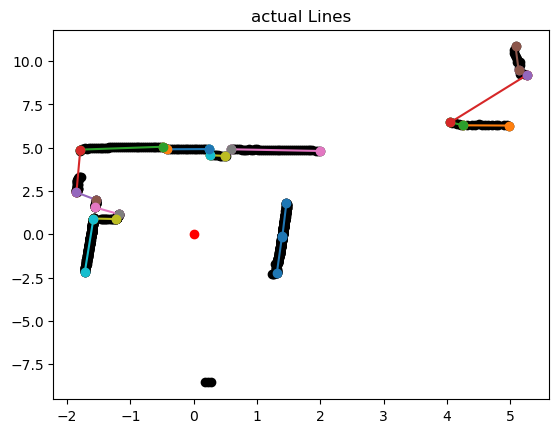

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.93496674e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00878596]]), array([[0.        , 0.        ],
       [0.        , 0.02143929]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.52204284e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00032781]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.56880821e-09]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.61997036e-05]]), array([[0.        , 0.        ],
       [0.        , 0.00018059]]), array([[0.        , 0.        ],
       [0.        , 0.00036034]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.07721351e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00011646]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.41529322e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00125866]]), array([[0.00000000e

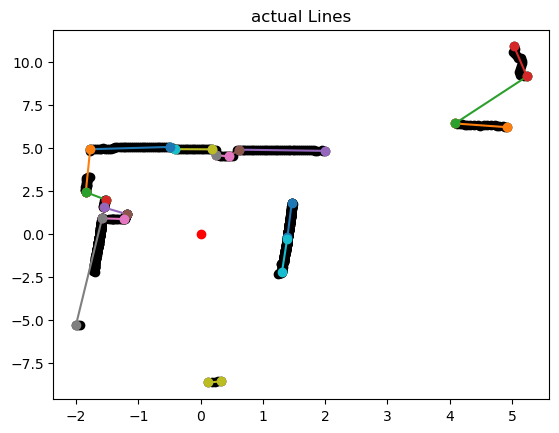

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.09916543e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00520556]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.79882709e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.31626306e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.66304069e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.49637608e-07]]), array([[0.       , 0.       ],
       [0.       , 0.0003549]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.79579144e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.68910221e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.30792641e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00138144]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.93788842e-12]]), array([[0.00000000e+00, 0.00000000e+00],
  

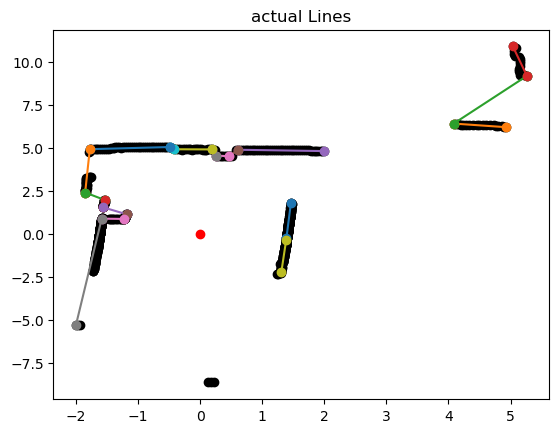

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.17152786e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00524608]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.84140261e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.65898338e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.59648755e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.49380886e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00035442]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.79670132e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.66637171e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.30900955e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00139061]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.94265275e-12]]), array([[0.00000000e+00, 0.00000000e+00]

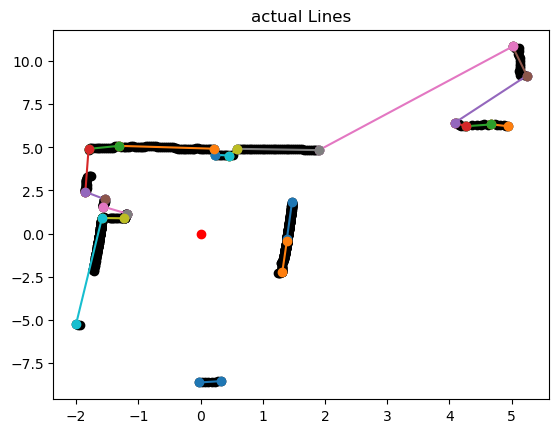

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.83705736e-11]]), array([[0.       , 0.       ],
       [0.       , 0.0252547]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.46024696e-05]]), array([[0.        , 0.        ],
       [0.        , 0.01662372]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.80960407e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.14616129e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.37502922e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.15946592e-05]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.6167517e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00034768]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.66359227e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00014912]]), array([[0.        , 0.        ],
       [0.        , 0.00546414

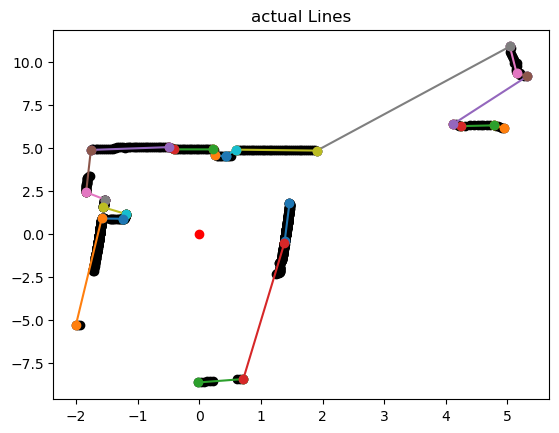

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.15693262e-11]]), array([[0.        , 0.        ],
       [0.        , 0.02346717]]), array([[0.        , 0.        ],
       [0.        , 0.01409812]]), array([[0.        , 0.        ],
       [0.        , 0.04323829]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.01107206e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00331997]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.76103172e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.34055098e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.38461101e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.33974582e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00034511]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.34500794e-05]]), array([[0.        , 0.        ],
       [0.        , 0.00011321]]), arr

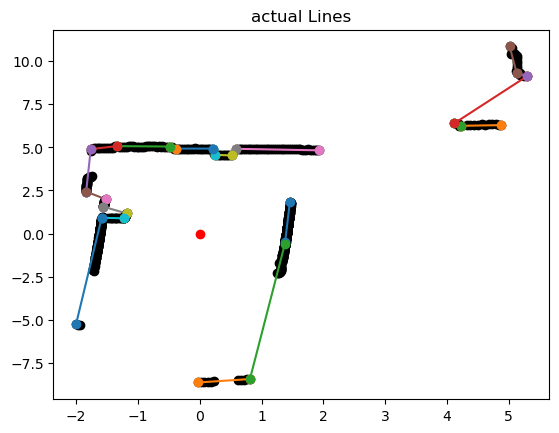

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.95957952e-11]]), array([[0.        , 0.        ],
       [0.        , 0.01321477]]), array([[0.        , 0.        ],
       [0.        , 0.03054639]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.96008897e-07]]), array([[0.       , 0.       ],
       [0.       , 0.0029399]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.84653917e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.66724618e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.04659979e-05]]), array([[0.       , 0.       ],
       [0.       , 0.0005828]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.14429348e-05]]), array([[0.        , 0.        ],
       [0.        , 0.00011626]]), array([[0.        , 0.        ],
       [0.        , 0.00955429]]), array([[0.        , 0.        ],
       [0.        , 0.00048751]]), array([[0.        , 0.     

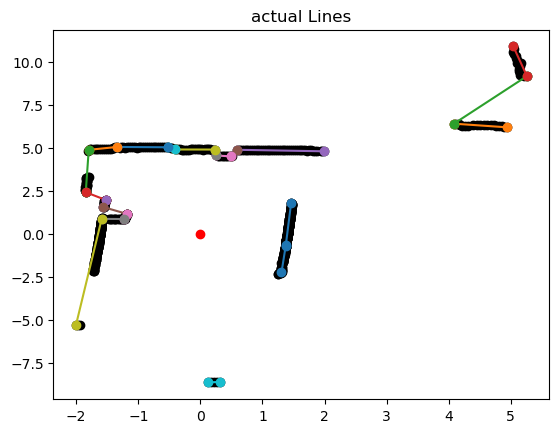

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.17349667e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00525899]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.82734042e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.50230341e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.86554232e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.51496805e-08]]), array([[0.        , 0.        ],
       [0.        , 0.00033565]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.35670595e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00010102]]), array([[0.        , 0.        ],
       [0.        , 0.00934903]]), array([[0.        , 0.        ],
       [0.        , 0.00371378]]), array([[0.        , 0.        ],
       [0.        , 0.00537088]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.1132559e-12]]), array([

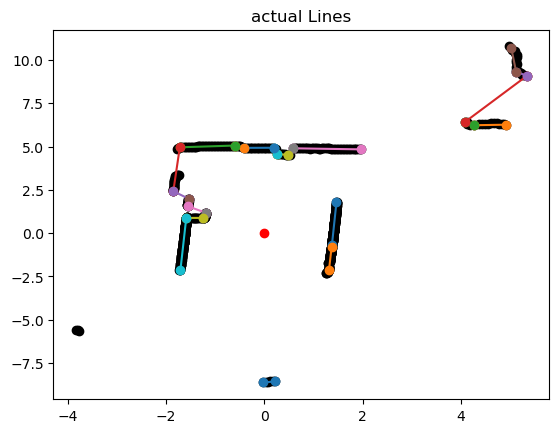

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.72176386e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00974908]]), array([[0.        , 0.        ],
       [0.        , 0.02444963]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.96807453e-07]]), array([[0.       , 0.       ],
       [0.       , 0.0038207]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.85501653e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.02565115e-05]]), array([[0.        , 0.        ],
       [0.        , 0.00018664]]), array([[0.        , 0.        ],
       [0.        , 0.00035571]]), array([[0.000000e+00, 0.000000e+00],
       [0.000000e+00, 1.633831e-08]]), array([[0.        , 0.        ],
       [0.        , 0.00010826]]), array([[0.        , 0.        ],
       [0.        , 0.00303946]]), array([[0.        , 0.        ],
       [0.        , 0.00149175]]), array([[0.00000000e+00, 0.00000000e+00],
      

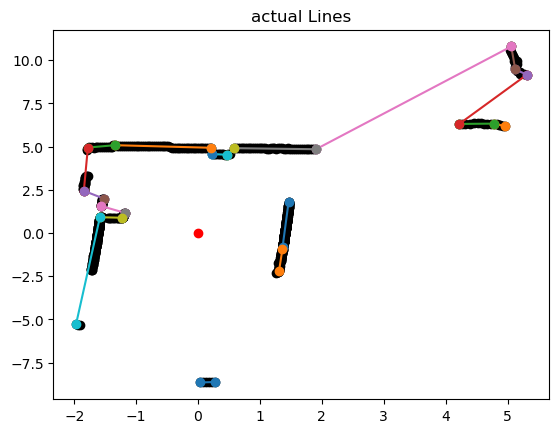

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.66581038e-11]]), array([[0.       , 0.       ],
       [0.       , 0.0242466]]), array([[0.        , 0.        ],
       [0.        , 0.01737357]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.17714791e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00066823]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.67884525e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.10680365e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.10008927e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.54973021e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00035043]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.57921851e-06]]), array([[0.       , 0.       ],
       [0.       , 0.0001017]]), array([[0.        , 0.        ],
       [0.        , 0.00656916]]), array([[0.0

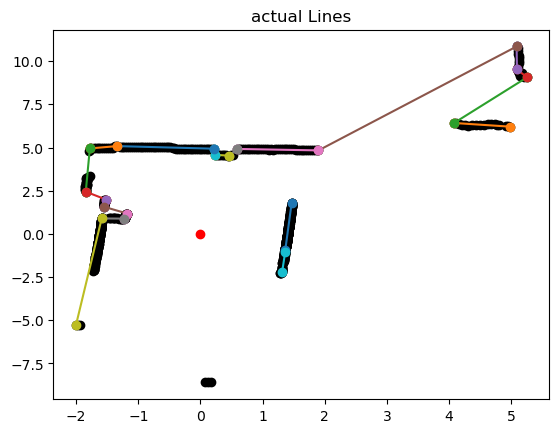

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.67776376e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00514918]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.63807701e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.16193903e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.36817142e-11]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.15545225e-07]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 8.9182335e-05]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.6681914e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00032699]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.67047621e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00010177]]), array([[0.        , 0.        ],
       [0.        , 0.00745028]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00

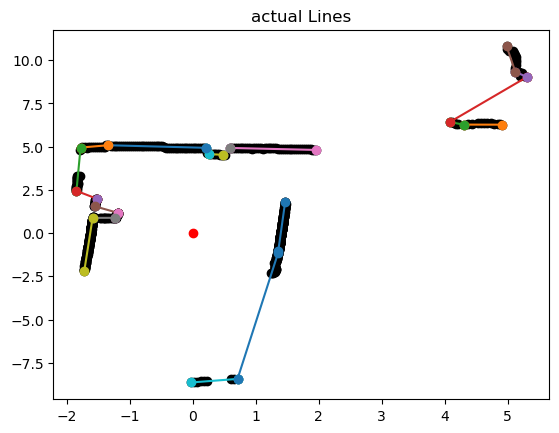

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.92832562e-11]]), array([[0.        , 0.        ],
       [0.        , 0.01078979]]), array([[0.        , 0.        ],
       [0.        , 0.03984799]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.89234967e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00116136]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.27329402e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00010044]]), array([[0.        , 0.        ],
       [0.        , 0.00016735]]), array([[0.        , 0.        ],
       [0.        , 0.00034118]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.10388533e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.63619016e-05]]), array([[0.        , 0.        ],
       [0.        , 0.00745028]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.18203811e-10]]), array([[0.0000000e+

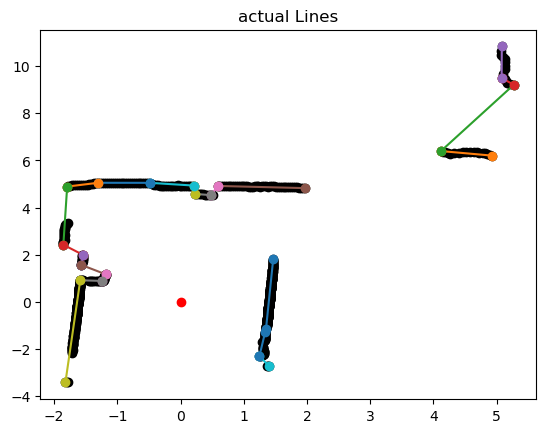

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.69154983e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00615987]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.28053924e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00299411]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.10898377e-11]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.27989735e-05]]), array([[0.        , 0.        ],
       [0.        , 0.00016811]]), array([[0.        , 0.        ],
       [0.        , 0.00032632]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.71832494e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00034247]]), array([[0.        , 0.        ],
       [0.        , 0.00191562]]), array([[0.        , 0.        ],
       [0.        , 0.00412456]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.29874386e-10]]), array([[0.00000000e

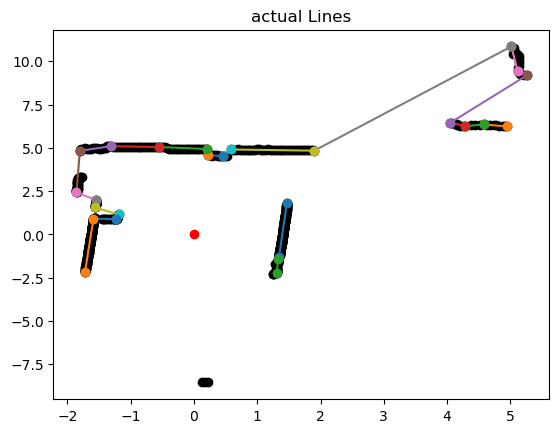

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.09697488e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00503767]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.14791426e-05]]), array([[0.        , 0.        ],
       [0.        , 0.01936595]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.54139528e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00047806]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.42889716e-08]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 5.3780609e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.03620744e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.55035536e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00032678]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.64259287e-06]]), array([[0.        , 0.        ],
       [0.        , 0.0003

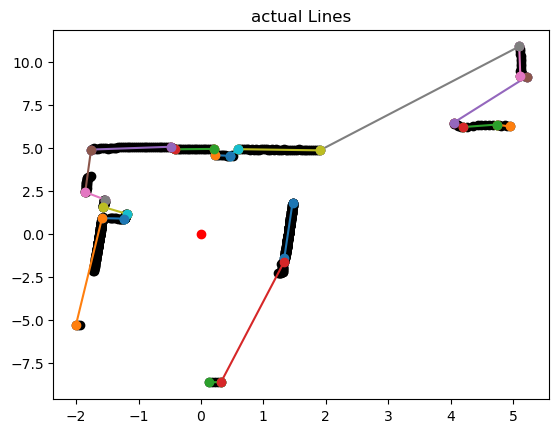

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.35961043e-11]]), array([[0.        , 0.        ],
       [0.        , 0.02818075]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.82257378e-05]]), array([[0.        , 0.        ],
       [0.        , 0.00399532]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 3.4564257e-07]]), array([[0.        , 0.        ],
       [0.        , 0.28402827]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0778452e-10]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.06008081e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.43379692e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.61694457e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00036117]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.47321203e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00014875

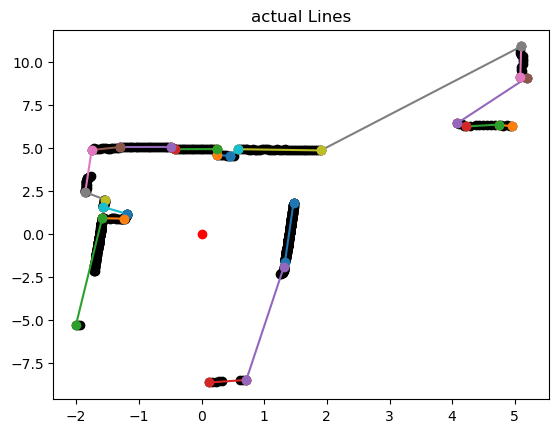

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.01452221e-11]]), array([[0.        , 0.        ],
       [0.        , 0.02943707]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.79182046e-05]]), array([[0.        , 0.        ],
       [0.        , 0.01826883]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.70667683e-07]]), array([[0.        , 0.        ],
       [0.        , 0.28751593]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.47931873e-11]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.00516793e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.44152479e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.56962216e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00034959]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.19584742e-12]]), array([[0.        , 0.        ],
       [0.        , 0.

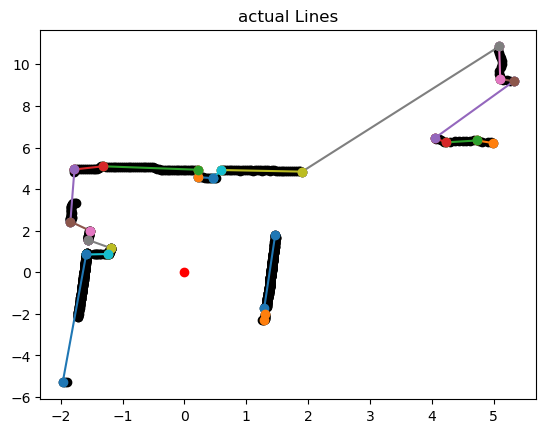

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.54495876e-11]]), array([[0.        , 0.        ],
       [0.        , 0.02316968]]), array([[0.        , 0.        ],
       [0.        , 0.01232287]]), array([[0.        , 0.        ],
       [0.        , 0.01135899]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.76605975e-07]]), array([[0.        , 0.        ],
       [0.        , 0.07428436]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.09945842e-10]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.08964363e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.15789226e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.61717731e-07]]), array([[0.       , 0.       ],
       [0.       , 0.0003488]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.46890042e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00012477]]), array([

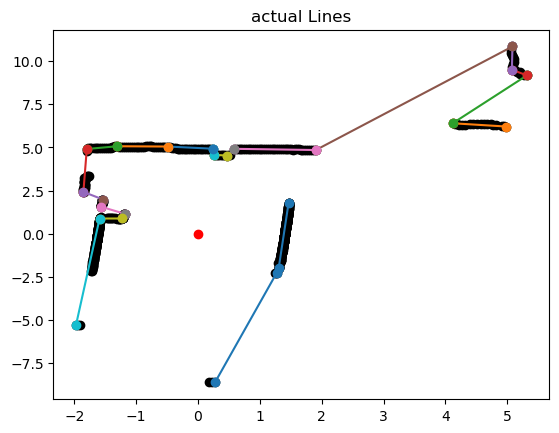

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.79051268e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00570132]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.03825266e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00108809]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.66009381e-11]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.10336001e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.03423071e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.61868396e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00034008]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.09975582e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00047608]]), array([[0.        , 0.        ],
       [0.        , 0.00343204]]), array([[0.        , 0.        ],
       [0.        , 0.00515367]]), arr

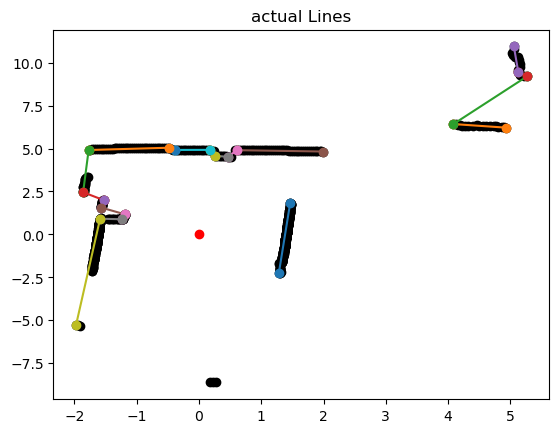

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.42268823e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00524967]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.8411816e-07]]), array([[0.       , 0.       ],
       [0.       , 0.0004605]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.86916828e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.78059189e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.49637052e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00035004]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.67216866e-08]]), array([[0.        , 0.        ],
       [0.        , 0.00010773]]), array([[0.        , 0.        ],
       [0.        , 0.00874549]]), array([[0.        , 0.        ],
       [0.        , 0.00146548]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.1465407e-09]]), array([[0.00000

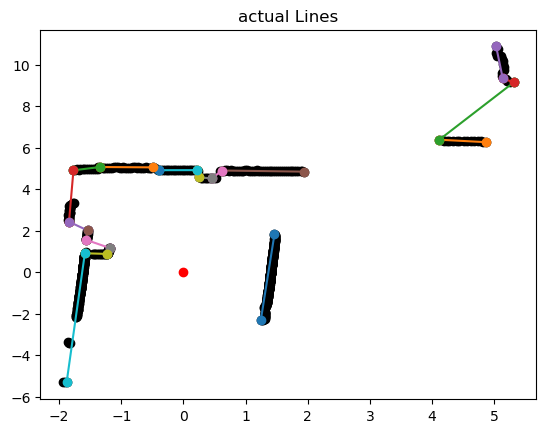

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.35472887e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00910674]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.02457161e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00510708]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.08420755e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.97872701e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.51955532e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00035594]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.33254102e-05]]), array([[0.        , 0.        ],
       [0.        , 0.00011353]]), array([[0.        , 0.        ],
       [0.        , 0.00823421]]), array([[0.        , 0.        ],
       [0.        , 0.00442373]]), array([[0.        , 0.        ],
       [0.        , 0.00685806]]), array([[0.00000000e

In [58]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


all_xt = []
all_xhat = []
# for robot_scans in range(len(scan_df)):
for robot_scans in range(20):

    # print(f'pos_t_minus1 = {pos_t_minus1}')
    x_hat, P_hat_t = position_prediction(pos_t_minus1, delta_sl, delta_sr, b, P_t_minus1)
    # print(f'x_hat = {x_hat}')
    
    # print(f'p_hat_t = {P_hat_t}')


    '''
    OBSERVATION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''

    # Run the split and merge and get covar
    # apply the split and merge algorithm


    Lines, points_in_line, line_alpha_rho = Algorithm_split_and_merge(scan_df[robot_scans].astype(float),threshold=0.1, plot=True)

    # Do covarience line fitting, save data to lists
    alphas = []
    rhos = []
    covars = []
    for i in range(len(points_in_line)):
        rho, alpha, C_l = covarience_line_fitting(points_in_line[i], line_alpha_rho[i])
        # line_info.append([alpha, rho, C_l])
        alphas.append(alpha)
        rhos.append(rho)
        covars.append(C_l)

    print(covars)
    # Create a dataframe with the good info
    all_scan_df = pd.DataFrame([alphas, rhos, covars, Lines, points_in_line], ['Alpha','rhos' ,'Covariance', 'Lines (endpoints)', ' Points within line'])



    # alpha and rho from the lidar data
    z_t = np.array([[all_scan_df.loc['Alpha'].astype(float)],
                [all_scan_df.loc['rhos'].astype(float)]])
    
    # Covariane matrix for eachlinec calculated
    R_t = np.array(all_scan_df.loc['Covariance'])

    '''
    MEASUREMENT PREDICTION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''
    ground_truth_df
    z_hat_t, H_j = measurement_prediction(x_hat, ground_truth_df)


    '''
    MATCHING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''
 

    matches, v_t_matches, sigmas_matches, H_j = matching(z_hat_t, z_t, R_t, H_j, P_hat_t, g)

   
    print(matches)
    for match in matches:
        i = match[0]
        j = match[1]
        print('robot_measurement',z_t[:,:,i])
        print('world frame match',z_hat_t[:,:,j])
    
    '''
    ESTIMATION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''
    # x_t, P_t = pos_estimation(H_j, x_hat, v_t_matches, P_hat_t, sigmas_matches)

    for i in range(len(H_j)):
        
        x_t, P_t = pos_estimation_v2(H_j[i], x_hat, v_t_matches[i], P_hat_t, sigmas_matches[i])
        print(x_t-x_hat)
        x_hat = x_t
        P_hat_t = P_t
    
    if len(H_j) < 1:
        P_t = P_hat_t
        x_t = x_hat
    P_t_minus1 = P_t

    pos_t_minus1 = x_t


    
    
    
    # print(f'pos_t_minus1 = {pos_t_minus1}')

    all_xt.append(x_t)
    all_xhat.append(x_hat)

    # print(f'Scan {robot_scans}')
    # print(f'x_t = {x_t}')
    # print(f'x_hat = {x_hat}')
    # print(f'covarience = {P_t}')

    # print('\n')
    # print('\n')

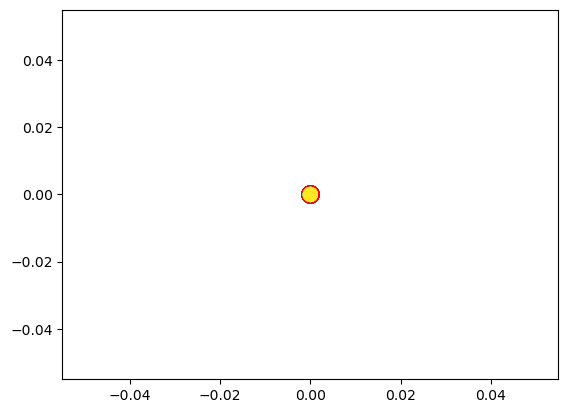

In [59]:
plt.figure()
color = []
for i in range(len(all_xt)):
    
    color.append(i/len(all_xt))
color = np.array(color)
plt.scatter(np.array(all_xhat)[:,0], np.array(all_xhat)[:,1], c='red',s = 150)
plt.scatter(np.array(all_xt)[:,0], np.array(all_xt)[:,1], c=color   ,s=100)
